Copyright (c) MONAI Consortium  
Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at  
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0  
Unless required by applicable law or agreed to in writing, software  
distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and  
limitations under the License.

# MONAI @ Learn2Reg Challenge
## Learn2Reg 2021 Task 3: MR Whole Brain

This tutorial shows how to use MONAI for the registration of unpaired MR volumes of the same modality. It is a fully MONAI-based solution for the Task 3: MR whole brain of the [Learn2Reg challenge 2021](https://learn2reg.grand-challenge.org/Learn2Reg2021/). Given two volumes sampled randomly from the dataset with one being the fixed (target) volume, and the other being the moving (source) volume, the task is to register the moving volume to the fixed volume. This task is considered an unpaired registration (or inter subject registration). This type of registration is useful for downstream tasks including voxel-based morphometry (VBM), atlas construction, and atlas-based segmentation, etc.

Each subject in the OASIS dataset has
1. Original 3D volume (not affinely aligned) `orig.nii.gz`, its bias-corrected and skull-stripped version `norm.nii.gz`, and its corresponding 4-label `seg4.nii.gz` and 35-label `seg35.nii.gz` segmentation maps,
2. Original 3D volume affinely aligned to freesurfer's talairach space `aligned_orig.nii.gz`, its bias-corrected and skull-stripped version `aligned_norm.nii.gz`, and its corresponding 4-label `aligned_seg4.nii.gz` and 35-label `aligned_seg35.nii.gz` segmentation maps, and
3. Original 2D slice (affinely aligned) `slice_orig.nii.gz`, its bias-corrected and skull-stripped version `slice_norm.nii.gz`, and its corresponding 4-label `slice_seg4.nii.gz` and 35-label `slice_seg35.nii.gz` segmentation maps.

For the sake of this notebook, only `aligned_norm.nii.gz` and `aligned_seg4.nii.gz` are used for training, and `aligned_seg35.nii.gz` is used only for validation and visualization. However, readers should feel free to explore using any or all of the available images. For example, the script provided in this notebook can be easily extended to use `aligned_seg35.nii.gz` for training. 

The challenge evaluate the goodness of registration in terms of three metrics, namely, DSC (dice similarity coefficient), HD95 (95% percentile of Hausdorff distance of segmentations), and SDlogJ (standard deviation of log Jacobian determinant of the deformation field). DSC and HD95 captures the how well the model aligns different anatomical structures while SDlogJ measures the smoothness of the predicted deformation between the fixed and moving images. For the sake of this notebook, only DSC is evaluated. 

This tutorial demonstrates several MONAI principles and has the following features:
1. Load OASIS challenge data (images and segmentation maps)
1. Define transforms for reading NIfTI files
1. Fast data loading and batching with `CacheDataset` and `DataLoader` 
1. Build `VoxelMorph` and custom forward function for prediction of dense displacement fields (DDF)
1. Warp an image with predicted DDFs and `Warp` block
1. Build a custom loss function using a combination of loss functions from MONAI and PyTorch
1. Compute Dice similarity coefficient between warped and fixed segmentation maps.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Project-MONAI/tutorials/blob/main/3d_registration/learn2reg_oasis_brain_mr.ipynb)

## Setup environment

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

## Setup imports

In [2]:
# python imports
import os
import glob
import json
import tempfile
import warnings
from pprint import pprint

# data science imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

# PyTorch imports
import torch
import torch.nn.functional as F
from torch.nn import MSELoss
from torch.utils.tensorboard import SummaryWriter

# MONAI imports
from monai.apps import download_and_extract
from monai.data import Dataset, CacheDataset, DataLoader
from monai.data.utils import list_data_collate
from monai.losses import BendingEnergyLoss, DiceLoss
from monai.metrics import DiceMetric, DiceHelper
from monai.networks.blocks import Warp
from monai.networks.nets import SegResNet, VoxelMorph
from monai.networks.utils import one_hot
from monai.utils import set_determinism, first
from monai.visualize.utils import blend_images
from monai.config import print_config
from monai.transforms import LoadImaged

set_determinism(seed=0)
torch.backends.cudnn.benchmark = True

# The flag below controls whether to allow TF32 on matmul. This flag defaults to False
# in PyTorch 1.12 and later.
torch.backends.cuda.matmul.allow_tf32 = True

# The flag below controls whether to allow TF32 on cuDNN. This flag defaults to True.
torch.backends.cudnn.allow_tf32 = True

warnings.filterwarnings("ignore")

print_config()

MONAI version: 1.4.dev2345
Numpy version: 1.24.4
Pytorch version: 2.1.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 08162c4c41783cb0218bda0da4db71a64daab87f
MONAI __file__: /home/<username>/miniforge3/envs/tutorial/lib/python3.8/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: 5.3.0
Nibabel version: 5.1.0
scikit-image version: 0.20.0
scipy version: 1.9.1
Pillow version: 10.1.0
Tensorboard version: 2.15.1
gdown version: 4.7.1
TorchVision version: 0.16.0
tqdm version: 4.66.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 2.0.3
einops version: 0.7.0
transformers version: 4.35.0
mlflow version: 2.8.0
pynrrd version: 0.4.2
clearml version: 1.13.2

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.
This allows you to save results and reuse downloads.
If not specified a temporary directory will be used.

In [3]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/DATA/MONAI/data


## Download dataset and prepare datalist
Download and extract the dataset:

In [4]:
resource = "https://surfer.nmr.mgh.harvard.edu/ftp/data/neurite/data/neurite-oasis.v1.0.tar"

compressed_file = os.path.join(root_dir, "neurite-oasis.v1.0.tar")
data_dir = os.path.join(root_dir, "OASIS")
if not os.path.exists(data_dir):
    os.mkdir(data_dir)
    download_and_extract(resource, compressed_file, data_dir)

Get list of samples in the dataset:

In [5]:
def get_files(data_dir):
    """
    Get train/val files from the full OASIS dataset
    """
    
    data_txt = os.path.join(data_dir, "subjects.txt")

    folders = []
    
    with open(data_txt,  'r') as file:
        for line in file:
            folders.append(str(line).strip())

    # load images and segmentations for training set
    train_files = []
    for folder in folders[:394]:
        train_files.append(
            {
                "image": os.path.join(data_dir, folder, "aligned_norm.nii.gz"),
                "label_4": os.path.join(data_dir, folder, "aligned_seg4.nii.gz"),
                "label_35": os.path.join(data_dir, folder, "aligned_seg35.nii.gz"),
            }
        )

    # load images and segmentations for validation set
    val_files = []
    for i, folder in enumerate(folders[394:-1]):
        next_folder = folders[394:][i + 1]
        val_files.append(
            {
                "fixed_image": os.path.join(data_dir, folder, "aligned_norm.nii.gz"),
                "moving_image": os.path.join(data_dir, next_folder, "aligned_norm.nii.gz"),
                "fixed_label_4": os.path.join(data_dir, folder, "aligned_seg4.nii.gz"),
                "moving_label_4": os.path.join(data_dir, next_folder, "aligned_seg4.nii.gz"),
                "fixed_label_35": os.path.join(data_dir, folder, "aligned_seg35.nii.gz"),
                "moving_label_35": os.path.join(data_dir, next_folder, "aligned_seg35.nii.gz"),
            }
        )

    return train_files, val_files


train_files, val_files = get_files(data_dir)

# print 1 training samples and 1 validation samples to illustrate the contents of the datalist
pprint(train_files[0])
pprint(val_files[0])

{'image': '/DATA/MONAI/data/OASIS/OASIS_OAS1_0001_MR1/aligned_norm.nii.gz',
 'label_35': '/DATA/MONAI/data/OASIS/OASIS_OAS1_0001_MR1/aligned_seg35.nii.gz',
 'label_4': '/DATA/MONAI/data/OASIS/OASIS_OAS1_0001_MR1/aligned_seg4.nii.gz'}
{'fixed_image': '/DATA/MONAI/data/OASIS/OASIS_OAS1_0438_MR1/aligned_norm.nii.gz',
 'fixed_label_35': '/DATA/MONAI/data/OASIS/OASIS_OAS1_0438_MR1/aligned_seg35.nii.gz',
 'fixed_label_4': '/DATA/MONAI/data/OASIS/OASIS_OAS1_0438_MR1/aligned_seg4.nii.gz',
 'moving_image': '/DATA/MONAI/data/OASIS/OASIS_OAS1_0439_MR1/aligned_norm.nii.gz',
 'moving_label_35': '/DATA/MONAI/data/OASIS/OASIS_OAS1_0439_MR1/aligned_seg35.nii.gz',
 'moving_label_4': '/DATA/MONAI/data/OASIS/OASIS_OAS1_0439_MR1/aligned_seg4.nii.gz'}


Define transforms for training and validation sets:

In [6]:
transform_train = LoadImaged(keys=["image", "label_4", "label_35"], ensure_channel_first=True)
transform_val = LoadImaged(
    keys=["fixed_image", "moving_image", "fixed_label_4", "moving_label_4", "fixed_label_35", "moving_label_35"],
    ensure_channel_first=True,
)

## Check transforms in DataLoader

Visualize a single batch with a single sample to check the transforms.

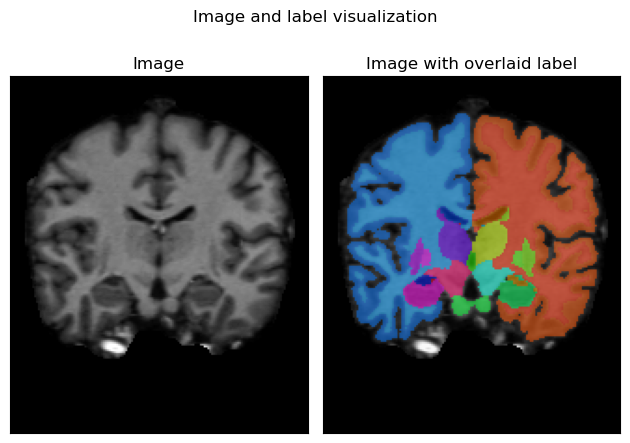

In [7]:
set_determinism(seed=0)
check_ds = Dataset(data=train_files, transform=transform_train)
check_loader = DataLoader(check_ds, batch_size=1, shuffle=True)
check_data = first(check_loader)

image = check_data["image"][0]
label = check_data["label_35"][0]
blended = blend_images(image, label)

# extract coronal slice 109
image = image.permute(2, 1, 3, 0)[:, :, 109, :]
blended = blended.permute(2, 1, 3, 0)[:, :, 109, :]

fig, axs = plt.subplots(1, 2)
axs[0].imshow(image, cmap="gray")
axs[0].title.set_text("Image")
axs[1].imshow(blended)
axs[1].title.set_text("Image with overlaid label")

plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])

plt.suptitle("Image and label visualization")
plt.tight_layout()
plt.show()

<a id='hyperparameters'></a>
## Set hyperparameters

A lot of customization and hyperparameter search can go into the exploration loss weights below. In this example, we will use the same loss weights as the [original VoxelMorph paper](https://arxiv.org/pdf/1809.05231.pdf). 

In [9]:
# device, optimizer, epoch and batch settings
device = "cuda" if torch.cuda.is_available() else "cpu"
batch_size = 1
lr = 1e-4
weight_decay = 1e-5
max_epochs = 1

# Use mixed precision feature of GPUs for faster training
amp_enabled = True

# loss weights (set to zero to disable loss term)
lam_sim = 1e0  # MSE (image similarity)
lam_smooth = 1e-2  # Bending loss (smoothness)
lam_dice = 2e-2  # Dice (auxiliary)

# whether to use coarse (4-label) or fine (35-label) labels for training
use_coarse_labels = True

#  Write model and tensorboard logs?
do_save = True
dir_save = os.path.join(os.getcwd(), "models", "voxelmorph")
if do_save and not os.path.exists(dir_save):
    os.makedirs(dir_save)

## Create custom forward pass

In [10]:
def forward(fixed_image, moving_image, moving_label, model, warp_layer, num_classes):
    """
    Model forward pass: predict DDF, convert moving label to one-hot format, and warping one-hot moving label using predicted DDF
    """

    # predict DDF and warp moving image using predicted DDF
    pred_image, ddf_image = model(moving_image, fixed_image)

    # warp moving label
    moving_label_one_hot = one_hot(moving_label, num_classes=num_classes + 1)  # num_classes + 1 to include background as a channel
    pred_label_one_hot = warp_layer(moving_label_one_hot, ddf_image)

    return ddf_image, pred_image, pred_label_one_hot

## Flexible multi-target loss function for various registration tasks

The custom method `loss_fun` below is a multi-target loss function. Feel free to tune the loss weights below and see their effect on the registration result. As a general rule-of-thumb, there is a trade-off between similarity loss and Dice loss, which encourage matching in appearance, and smoothness loss, which encourages smoothness of DDF.

Out of the box, MONAI has several losses in store that can be used to train a deep (medical) image registration model. For image similarity, one has:
- Single-modal image similarity via LNCC ([LocalNormalizedCrossCorrelationLoss](https://docs.monai.io/en/stable/losses.html#localnormalizedcrosscorrelationloss)).
- Multi-modal image similarity via mutual information ([GlobalMutualInformationLoss](https://docs.monai.io/en/stable/losses.html#globalmutualinformationloss))

For deformation smoothness, one has:
- Warp field regularization ([BendingEnergyLoss](https://docs.monai.io/en/stable/losses.html#bendingenergyloss))

The `loss_fun` further demonstrates that it is natively possible to incorporate PyTorch losses (e.g. [MESLoss](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html)).

To get started, the weights in this tutorial are set to match the [original VoxelMorph paper](https://arxiv.org/pdf/1809.05231.pdf). However, further experiments with different weight combinations are encouraged (see "[Next Steps](#nextsteps)").

In [11]:
def loss_fun(
    fixed_image,
    pred_image,
    fixed_label,
    pred_label_one_hot,
    ddf_image,
    lam_sim,
    lam_smooth,
    lam_dice,
):
    """
    Custom multi-target loss:
        - Image similarity: MSELoss
        - Deformation smoothness: BendingEnergyLoss
        - Auxiliary loss: DiceLoss
    """
    # Instantiate where necessary
    if lam_sim > 0:
        mse_loss = MSELoss()
    if lam_smooth > 0:
        regularization = BendingEnergyLoss()
    if lam_dice > 0:
        label_loss = DiceLoss(include_background=False)  # we exclude the first channel (i.e., background) when calculating dice

    num_classes = 4 if use_coarse_labels else 35

    # Compute loss components
    sim = mse_loss(pred_image, fixed_image) if lam_sim > 0 else 0
    smooth = regularization(ddf_image) if lam_smooth > 0 else 0
    dice = label_loss(pred_label_one_hot, one_hot(fixed_label, num_classes=num_classes + 1)) if lam_dice > 0 else 0
    
    # Weighted combination:
    return lam_sim * sim + lam_smooth * smooth + lam_dice * dice

## Define CacheDataset and DataLoader for training and validation

Here we use the regular `Dataset` but one can opt to use `CacheDataset` to accelerate training and validation process.

To achieve best performance, set cache_rate=1.0 to cache all the data, if memory is not enough, set lower value.
Users can also set cache_num instead of cache_rate, will use the minimum value of the 2 settings.
And set num_workers to enable multi-threads during caching.

In [12]:
# Cached datasets for high performance during batch generation
# train_ds = CacheDataset(data=train_files, transform=transform_train, cache_rate=1.0, num_workers=1)
# val_ds = CacheDataset(data=val_files, transform=transform_val, cache_rate=1.0, num_workers=1)
train_ds = Dataset(data=train_files, transform=transform_train)
val_ds = Dataset(data=val_files, transform=transform_val)

# We sample two batches from the train_loader to make a pair of fixed and moving images
train_loader = DataLoader(train_ds, batch_size=2 * batch_size, shuffle=True, num_workers=1)

# We sample one batch since each batch is already a pair of fixed and moving images
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=1)

## Create model/optimizer/metrics

Here we load the model `VoxelMorph` as our framework, which is intended to be used as a general framework, based on which a deformable image registration network can be built with customizable backbones. An instance of `VoxelMorph` contains:
1. A `backbone` model, which takes the fixed and moving image pair concatenated along the channel dimension as input and predicts a stationary velocity field (DVF),
2. A velocity field integration layer ([DVF2DDF](https://docs.monai.io/en/latest/networks.html#monai.networks.blocks.DVF2DDF)), and
3. A warp layer ([Warp](https://docs.monai.io/en/latest/networks.html#monai.networks.blocks.Warp)).

In this notebook, we use the default `backbone` model, which is set to use `VoxelMorphUNet` as described in the [original VoxelMorph paper](https://arxiv.org/pdf/1809.05231.pdf). However, readers are encouraged to try any other appropriate model for the `backbone`.

For a `backbone` model to fit the `VoxelMorph` framework, it must be able to take input of shape `(batch, 2*num_channels, H, W[, D])` and output a DVF of shape `(batch, spatial_dims, H, W[, D])`, where `num_channels` is the number of channels of the fixed/moving volume, `spatial_dims` is the number of spatial dimensions (i.e. `spatial_dims=3` for 3D images), and `batch` is the batch size.

For more information, see the documentations on [VoxelMorph](https://docs.monai.io/en/latest/networks.html#monai.networks.nets.VoxelMorph) and [VoxelMorphUNet](https://docs.monai.io/en/latest/networks.html#monai.networks.nets.VoxelMorphUNet).

In [13]:
# Model
model = VoxelMorph().to(device)
warp_layer = Warp().to(device)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

# Metrics
dice_metric_before = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
dice_metric_after = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)

## Execute a typical PyTorch training process

In the following cell, we provide a training snippet that trains for 100 epochs using (optional) automatic mixed precision (AMP) for acceleration, which is sufficient to reproduce the result in the [original VoxelMorph paper](https://arxiv.org/pdf/1809.05231.pdf).

In [18]:
# Automatic mixed precision (AMP) for faster training
amp_enabled = True
scaler = torch.cuda.amp.GradScaler()

# Tensorboard
if do_save:
    writer = SummaryWriter(log_dir=dir_save)

# Start torch training loop
val_interval = 1
best_eval_dice = 0
log_train_loss = []
log_val_dice = []
pth_best_dice, pth_latest = "", ""

for epoch in range(max_epochs):
    # ==============================================
    # Train
    # ==============================================
    model.train()

    epoch_loss, n_steps = 0, 0
    for batch_data in train_loader:
    # for batch_data in tqdm(train_loader):
        # Get data
        fixed_image = batch_data["image"][0:1, ...].to(device)
        moving_image = batch_data["image"][1:, ...].to(device)
        if use_coarse_labels:
            fixed_label = batch_data["label_4"][0:1, ...].to(device)
            moving_label = batch_data["label_4"][1:, ...].to(device)
        else:
            fixed_label = batch_data["label_35"][0:1, ...].to(device)
            moving_label = batch_data["label_35"][1:, ...].to(device)
        n_steps += 1

        # Forward pass and loss
        optimizer.zero_grad()
        with torch.cuda.amp.autocast(enabled=amp_enabled):
            ddf_image, pred_image, pred_label_one_hot = forward(
                fixed_image, moving_image, moving_label, model, warp_layer, num_classes=4
            )
            loss = loss_fun(
                fixed_image,
                pred_image,
                fixed_label,
                pred_label_one_hot,
                ddf_image,
                lam_sim,
                lam_smooth,
                lam_dice,
            )
        # Optimise
        # loss.backward()
        # optimizer.step()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()

    # Scheduler step
    lr_scheduler.step()
    # Loss
    epoch_loss /= n_steps
    log_train_loss.append(epoch_loss)
    if do_save:
        writer.add_scalar("train_loss", epoch_loss, epoch)
    print(f"{epoch + 1} | loss = {epoch_loss:.6f}")

    # ==============================================
    # Eval
    # ==============================================
    if (epoch + 1) % val_interval == 0:
        model.eval()

        n_steps = 0
        with torch.no_grad():
            for batch_data in val_loader:
                # Get data
                fixed_image = batch_data["fixed_image"].to(device)
                moving_image = batch_data["moving_image"].to(device)
                fixed_label_4 = batch_data["fixed_label_4"].to(device)
                moving_label_4 = batch_data["moving_label_4"].to(device)
                # fixed_label_35 = batch_data["fixed_label_35"].to(device)
                # moving_label_35 = batch_data["moving_label_35"].to(device)
                n_steps += 1
                # Infer
                with torch.cuda.amp.autocast(enabled=amp_enabled):
                    ddf_image, pred_image, pred_label_one_hot = forward(
                        fixed_image, moving_image, moving_label_4, model, warp_layer, num_classes=4
                    )
                # Dice
                dice_metric_before(y_pred=moving_label_4, y=fixed_label_4)
                dice_metric_after(y_pred=pred_label_one_hot.argmax(dim=1, keepdim=True), y=fixed_label_4)
                # Note: DiceMetric does work with one-hot encoded inputs. However, recall that when we defined the forward pass, we first 
                # converted the discrete moving label into one-hot format, and then warp the one-hot encoded moving label (which by default 
                # uses bilinear interpolation). Passing a non-binary one-hot label as y_pred is not supported by DiceMetric. DiceHelper does
                # but we are not using DiceHelper since it does not inherit from CumulativeIterationMetric and is, thus, unable to accumulate
                # statistics.

                # # uncomment this block of code to show a pair of fixed and moved image at each validation
                # if n_steps == 1:
                #     fig, axs = plt.subplots(1, 2)
                #     fixed = fixed_image.cpu().squeeze().permute(1, 0, 2)[:, :, 109]
                #     axs[0].imshow(fixed, cmap="gray")
                #     axs[0].title.set_text("Fixed")
                #     moving = pred_image.detach().cpu().squeeze().permute(1, 0, 2)[:, :, 109]
                #     axs[1].imshow(moving, cmap="gray")
                #     axs[1].title.set_text("Moved")
                #     plt.show()

        # Dice
        dice_before = dice_metric_before.aggregate().item()
        dice_metric_before.reset()
        dice_after = dice_metric_after.aggregate().item()
        dice_metric_after.reset()
        if do_save:
            writer.add_scalar("val_dice", dice_after, epoch)
        log_val_dice.append(dice_after)
        print(f"{epoch + 1} | dice_before = {dice_before:.3f}, dice_after = {dice_after:.3f}")

        if dice_after > best_eval_dice:
            best_eval_dice = dice_after
            if do_save:
                # Save best model based on Dice
                if pth_best_dice != "":
                    os.remove(os.path.join(dir_save, pth_best_dice))
                pth_best_dice = f"voxelmorph_loss_best_dice_{epoch + 1}_{best_eval_dice:.3f}.pth"
                torch.save(model.state_dict(), os.path.join(dir_save, pth_best_dice))
                print(f"{epoch + 1} | Saving best Dice model: {pth_best_dice}")

    if do_save:
        # Save latest model
        if pth_latest != "":
            os.remove(os.path.join(dir_save, pth_latest))
        pth_latest = "voxelmorph_loss_latest.pth"
        torch.save(model.state_dict(), os.path.join(dir_save, pth_latest))

1 | loss = 0.008120
1 | dice_before = 0.497, dice_after = 0.634
1 | Saving best Dice model: voxelmorph_loss_best_dice_1_0.634.pth


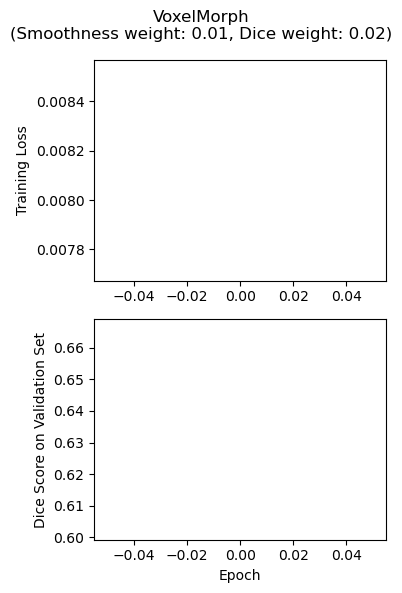

In [19]:
fig, axs = plt.subplots(2, 1, figsize=(4, 6))
axs[0].plot(log_train_loss)
# axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Training Loss")
axs[1].plot(log_val_dice)
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Dice Score on Validation Set")
plt.suptitle(f"VoxelMorph\n(Smoothness weight: {lam_smooth}, Dice weight: {lam_dice})")
plt.tight_layout()
plt.show()

## Visualize registration performance of trained network

#### Load pretrained model and perform forward pass

In [20]:
load_pretrained_model_weights = True
if load_pretrained_model_weights:
    dir_load = dir_save  # folder where network weights are stored
    # instantiate warp layer
    warp_layer = Warp().to(device)
    # instantiate model
    model = VoxelMorph()
    # load model weights
    filename_best_model = glob.glob(os.path.join(dir_load, "voxelmorph_loss_best_dice_*"))[0]
    model.load_state_dict(torch.load(filename_best_model))
    # to GPU
    model.to(device)

set_determinism(seed=1)
check_ds = Dataset(data=val_files, transform=transform_val)
check_loader = DataLoader(check_ds, batch_size=1, shuffle=True)
check_data = first(check_loader)

# Get data
fixed_image = check_data["fixed_image"].to(device)
moving_image = check_data["moving_image"].to(device)
fixed_label_4 = check_data["fixed_label_4"].to(device)
moving_label_4 = check_data["moving_label_4"].to(device)
fixed_label_35 = check_data["fixed_label_35"].to(device)
moving_label_35 = check_data["moving_label_35"].to(device)

# Forward pass
model.eval()
with torch.no_grad():
    with torch.cuda.amp.autocast(enabled=amp_enabled):
        ddf_image, pred_image, pred_label_one_hot = forward(
            fixed_image, moving_image, moving_label_35, model, warp_layer, num_classes=35
        )

#### Visualization of fixed/moving/moved images and labels

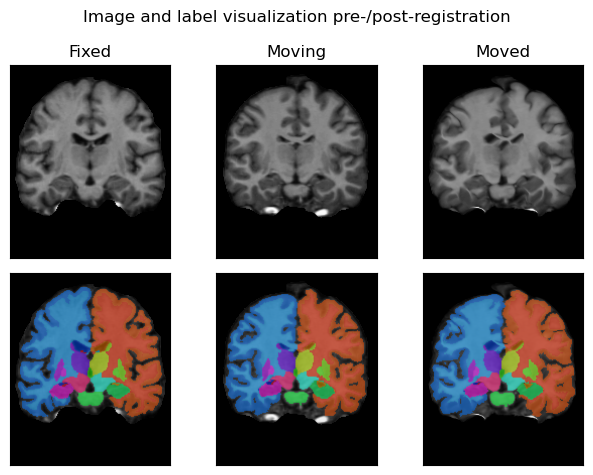

In [21]:
# Image and label visualization
def visualize(fixed_image, fixed_label, moving_image, moving_label, pred_image, pred_label_one_hot):
    # remove the batch dimension and move to cpu
    fixed_image = fixed_image.squeeze(0).cpu()
    fixed_label = fixed_label.squeeze(0).cpu()
    moving_image = moving_image.squeeze(0).cpu()
    moving_label = moving_label.squeeze(0).cpu()
    pred_image = pred_image.squeeze(0).cpu()
    pred_label = pred_label_one_hot.argmax(dim=1, keepdim=True).squeeze(0).cpu()

    # blend image and label
    fixed_blended = blend_images(fixed_image, fixed_label)
    moving_blended = blend_images(moving_image, moving_label)
    pred_blended = blend_images(pred_image, pred_label)
    
    # extract coronal slice 109 and transpose 
    fixed_image = fixed_image.permute(2, 1, 3, 0)[:, :, 109, :]
    moving_image = moving_image.permute(2, 1, 3, 0)[:, :, 109, :]
    pred_image = pred_image.permute(2, 1, 3, 0)[:, :, 109, :]

    fixed_blended = fixed_blended.permute(2, 1, 3, 0)[:, :, 109, :]
    moving_blended = moving_blended.permute(2, 1, 3, 0)[:, :, 109, :]
    pred_blended = pred_blended.permute(2, 1, 3, 0)[:, :, 109, :]

    # create plot
    fig, axs = plt.subplots(2, 3)
    axs[0, 0].imshow(fixed_image, cmap="gray")
    axs[0, 0].title.set_text("Fixed")
    axs[0, 1].imshow(moving_image, cmap="gray")
    axs[0, 1].title.set_text("Moving")
    axs[0, 2].imshow(pred_image, cmap="gray")
    axs[0, 2].title.set_text("Moved")
    axs[1, 0].imshow(fixed_blended)
    axs[1, 1].imshow(moving_blended)
    axs[1, 2].imshow(pred_blended)
    
    # remove ticks on all axes
    plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])

    # set title
    plt.suptitle("Image and label visualization pre-/post-registration")
    plt.tight_layout()
    plt.show()

visualize(fixed_image, fixed_label_35, moving_image, moving_label_35, pred_image, pred_label_one_hot)

<a id='nextsteps'></a>
## Next steps

The registration network has been trained and generalizes well to unseen image pairs in the validation set. As next steps, readers can:

- Inspect other validation cases by looping through the validation and visualizing registration results.
- Try different combinations of loss weights for the multi-target loss `loss_fun()` in code cell [Hyperparameters](#hyperparameters), e.g., increasing the loss weight for deformation smoothness (`lam_smooth`).
- Try different loss functions, e.g., replacing `MSELoss` with `LocalNormalizedCrossCorrelationLoss`.
- Train the network longer, i.e., use `max_epochs = 2000` in cell [Hyperparameters](#hyperparameters). 
- With MONAI, it is very easy to swap out the `backbone` in the `VoxelMorph` framework for other SOTA models, e.g., 3D vision transformer-based architectures like [UNETR](https://docs.monai.io/en/stable/networks.html#unetr) or Swin-Transformer-based architectures like [SwinUNETR](https://docs.monai.io/en/stable/networks.html#swinunetr). It is also possible to bring-your-own-model (BYOM), as long as the model architecture derives from `torch.nn.Module` and is appropriate (see [Create model](#Create-model/optimizer/metrics)).

For further information on how to prepare a challenge submission from these results, please visit official recommendations from the [Learn2Reg](https://learn2reg.grand-challenge.org/) website. 